Acesse um *preview* interativo deste notebook por [aqui](https://nbviewer.org/github/VanessaWille/Search_Engine/blob/main/models_comparison.ipynb).

# Comparação de Modelos

Para essa tarefa, temos um conjunto de consultas que foram realizadas em diferentes modelos e avaliadas com a ajuda de um *LLM*. Vamos carregá-las e usá-las para calcular as pontuações dos resultados de pesquisa dos modelos.

## Imports

Primeiro, vamos importar as bibliotecas necessárias. Estas são:

- `numpy` para manuseio de *arrays*;
- `os` para manuseio de diretórios;
- `pandas` para utilizar *DataFrames*;
- `plotly.express` para criação de gráficos interativos;
- `plotly.io` para configurar gráficos *Plotly*;
- `re` para operações *RegEx*.

In [18]:
# Bibliotecas
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import re

Vamos definir o renderizador para os gráficos *Plotly*:

In [19]:
# Renderizador de notebooks
pio.renderers.default = "notebook"

## Carregando resultados avaliados

Todos os pares de consulta e resultado retornados pelos modelos são avaliados de 0 a 5 em termos de relevância de acordo com a consulta. Temos um banco de pares já avaliados, salvos no arquivo `review_bank.xlsx`. Estes resultados foram avaliados em três modelos diferentes - *BM25*, *TF-IDF* e *e5* pelos integrantes de nosso grupo. Por fim, foi calculado uma média e eles foram arredondados para se encaixarem no padrão de 0 a 5.

Vamos tentar coletar suas informações em um *DataFrame*:

In [20]:
# Tenta ler o arquivo review_bank.xlsx e transformar num DataFrame
try:
    review_bank = pd.read_excel('reviews/review_bank.xlsx')
# Caso não funcione, cria um Dataframe vazio
except:
    review_bank = pd.DataFrame()

Os resultados de uma consulta feita a um modelo que ainda não estão no banco são adicionados ao arquivo `missing_reviews_bank.xlsx`. Dentre esses, estão aqueles ainda não avaliados e os que foram avaliados por um *LLM*. No nosso caso, tivemos avaliações feitas pelo *GPT* e pelo *LLamMa3*.

Vamos tentar salvar essas informações em um *DataFrame* e, caso possível, vamos coletar as entradas já avaliadas e adicioná-las ao banco de dados `review_bank`, para que ele englobe todas as respostas.

In [21]:
# Tenta ler o arquivo missing_reviews_bank.xlsx e transformar num DataFrame
try:
    missing_reviews_bank = pd.read_excel("reviews/missing_reviews_bank.xlsx")
    # Salva as entradas com Nota em outra tabela
    extra_reviews = missing_reviews_bank[missing_reviews_bank["Nota"] != None]
    # Adapta e filtra as colunas
    extra_reviews.rename(columns={"title": "Receita"}, inplace=True)
    extra_reviews[["Tipo", "Descrição", "Query", "Receita", "Evaluator", "Nota"]]
    # Atualiza a tabela com as entradas já avaliadas
    review_bank = pd.concat([review_bank, extra_reviews])
# Caso não seja possível, cria um DataFrame vazio
except:
    missing_reviews_bank = pd.DataFrame()

Para coletar a nota do resultado de uma receita para uma *query* específica, vamos criar uma função chamada `lookup_rating`, que leva como parâmetros a *query* e a receita. Vamos tentar filtrar o DataFrame `review_bank`, já com todas as receitas avaliadas, para que retorne apenas as entradas que atendam ao par de *query*/receita. 

As colunas relevantes serão a nota e o avaliador, que pode ser uma pessoa ou um *LLM*. Dessa forma, retornamos a nota, com preferência sendo dada às respostas fornecidas por pessoas, uma vez que temos maior controle de sua qualidade.

In [22]:
# Função para retornar a nota de uma receita dada uma query
def lookup_rating(query, recipe):
    # Tenta coletar a nota da receita
    try:
        # Filtra o DataFrame com todas as receitas avaliadas para bater com o par de query/receita
        ratings = review_bank[(review_bank['Query'] == query) & (review_bank['Receita'] == recipe)][["Nota", "Evaluator"]]
        # Tenta coletar a linha onde o avaliador é uma pessoa
        person_rating = ratings[ratings['Evaluator'] == "Person"]
        # Caso esta linha não esteja vazia, retorna a nota dada por pessoas
        if not person_rating.empty:
            return person_rating.values[0][0]
        # Caso contrário, retorna a primeira nota dada por LLMs.
        else:
            nota = ratings.iloc[0].values[0]
            return nota
    # Caso não funcione, retorna None.
    except:
        return None

## Resultados dos modelos

Cada modelo deve gerar o resultado de sua avaliação na pasta `/output`, no formato `.xlsx` e com o nome seguindo o padrão `Results_[Model_name].xlsx`. Vamos criar uma lista com esses arquivos:

In [23]:
# Padrão a ser encontrado nos arquivos
pattern = r"Results_.*\.xlsx$"
# Busca os arquivos na pasta de output por matching de RegEx
model_results_paths = [os.path.join('output', file) for file in os.listdir('output') if re.match(pattern, file)]

Nestas planilhas, cada modelo retornará as 5 melhores receitas para cada *query* de nosso banco de *queries* presente em `input/Recipe_Search_Questions.xlsx`. As *queries* são divididas em duas categorias, *Keywords* e *Semantic*. A primeira apresenta apenas as palavras-chaves do que se procura, sendo direto ao ponto. As perguntas consideradas "Simples" são deste tipo. Enquanto isso, perguntas do tipo *Semantic* possuem informações onde o contexto deve ser considerado para retornar algo realmente relevante, como a noção de exclusão de algum item específico. Perguntas deste tipo possuem dificuldade "Média", "Díficil" ou "Difícil+" (denominadas também de Complexas).

Vamos criar um dicionário, onde o nome do modelo será a chave e seus resultados serão a chave. Temos atualmente quatro modelos, sendo estes o *TF-IDF*, *BM25*, um modelo semântico utilizando *e5* e um modelo híbrido que combina os últimos dois.

In [24]:
# Dicionário para salvar os resultados dos modelos
models = {}
# Percorre os caminhos relevantes da lista
for model_result_path in model_results_paths:
    # Coleta o nome do modelo pelo arquivo
    model_name = re.search(r"Results_(.*).xlsx", os.path.basename(model_result_path)).group(1)
    # Cria um DataFrame com os resultados
    result_df = pd.read_excel(model_result_path)
    # Cria uma coluna de nota utilizando a função lookup_rating
    result_df["Nota"] = result_df.apply(lambda row: lookup_rating(row['Query'], row['title']), axis=1)
    # Cria o par chave/valor para o dicionário
    models[model_name] = result_df

# Avaliação dos modelos

Para fins de comparação de cada modelo, vamos calcular a média das notas para cada grupo de perguntas. Isso envolve a separação por diferentes valores na coluna Descrição (dificuldade da pergunta) e por diferentes valores na coluna Tipo (semântica ou palavra-chave).

In [25]:
# Cria um DataFrame para resultados sem nota
missing_reviews = pd.DataFrame()
# Cria dicionários para armazenar as médias, baseada na dificuldade da pergunta
simple_mean = {}
media_mean = {}
hard_mean = {}
complex_mean = {}
# Cria dicionários para armazenar as médias, baseada no tipo de pergunta
semantic_mean = {}
keyword_mean = {}
# Cria dicionário para a média geral
mean = {}
df_initial_report = pd.DataFrame()
# Percorre os modelos do dicionário
for model in models:
    # Cria um DataFrame para os resultados
    df = models[model]
    # Coleta as linhas sem nota do DataFrame
    model_missing_reviews = df[df['Nota'].isnull()]
    # Cria DataFrames filtrados para cada dificuldade
    simple_question = df[df['Descrição'] == 'Pergunta simples']
    media_question = df[df['Descrição'] == 'Pergunta média']
    hard_question = df[df['Descrição'] == 'Pergunta difícil']
    complex_question = df[df['Descrição'] == 'Pergunta difícil +']
    # Cria DataFrames filtrados para cada tipo de pergunta
    keyword = df[df['Tipo'] == 'Keywords']
    semantic = df[df['Tipo'] == 'Semantica']
    # Adiciona as notas médias nos dicionários de dificuldade
    simple_mean[model] = simple_question['Nota'].mean()
    media_mean[model] = media_question['Nota'].mean()
    hard_mean[model] = hard_question['Nota'].mean()
    complex_mean[model] = complex_question['Nota'].mean()
    # Nota média do modelo
    model_mean = df['Nota'].mean()
    mean[model] = model_mean
    # Adiciona as notas médias nos dicionários de tipo de pegrgunta
    keyword_mean[model] = keyword['Nota'].mean()
    semantic_mean[model] = semantic['Nota'].mean()
    
    # Adiciona as linhas sem avaliação ao DataFrame
    missing_reviews = pd.concat([missing_reviews, model_missing_reviews])

    report_row = pd.DataFrame({
        "Modelo": [model],
        "Média": [model_mean],
        "Avaliações ausentes": [len(model_missing_reviews)],
        "Perguntas respondidas": [df["Query"].nunique()],
        "Fração de respostas avaliadas": [str(round((1 - len(model_missing_reviews) / df["Query"].count() ) *100 , 2))+"%"],
    })

    df_initial_report = pd.concat([df_initial_report, report_row], ignore_index=True)
df_initial_report

,Modelo,Média,Avaliações ausentes,Perguntas respondidas,Fração de respostas avaliadas
0,10K_bm25_body,0.692683,0,41,100.0%
1,10K_debug_bm25_all_fields,0.859091,0,44,100.0%
2,10K_debug_bm25_no_body,0.868182,0,44,100.0%
3,10K_debug_bm25_no_description,0.890909,0,44,100.0%
4,10K_debug_bm25_no_ingredients,0.895455,0,44,100.0%
5,10K_debug_bm25_no_steps,0.963636,0,44,100.0%
6,10K_debug_bm25_no_tags,0.854545,0,44,100.0%
7,10K_debug_bm25_no_title,0.850000,0,44,100.0%
8,10K_hybrid_body_e5,1.497561,0,41,100.0%
9,10K_semantic_body_e5,2.692683,0,41,100.0%


Também calcularemos o *nDCG (Normalized Discounted Cumulative Gain)* para utilizarmos como métrica de desempenho. Primeiro, vamos utilizar esta fórmula para o *DCG* padrão:

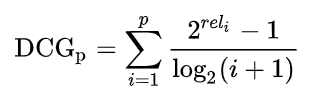

Vamos criar uma função para calculá-la:

In [26]:
# Função para calcular o DCG
def calculate_dcg(scores):
    # Versão alternativa: menos foco em relevantes:
    # return sum(score / np.log2(idx + 2) for idx, score in enumerate(scores))
    return sum((2**score - 1) / np.log2(idx + 2) for idx, score in enumerate(scores))

Vamos criar uma função para calcular o *IDCG* - *Ideal Discounted Cumulative Gain*, onde temos a melhor ordem dos documentos:

In [27]:
# Função para calcular o IDCG
def calculate_idcg(scores):
    # Ordena os documentos da melhor forma
    sorted_scores = sorted(scores, reverse=True)
    # Calcula o DCG dessa ordenação
    return calculate_dcg(sorted_scores)

Por fim, temos que o *nDCG* é calculado pela razão entre a pontuação *DCG* e a pontuação *IDCG*.

Podemos assim calcular o *nDCG* para cada *query* de um modelo. Para calcular a nota *nDCG* final de um modelo, basta realizar a média do valor obtido em cada *query*. Vamos criar uma função auxiliar para isto:

In [28]:
# Função para retornar o DCG de um modelo
def final_dcg(df, ndcg = True):
    # Agrupa o DataFrame por queries
    grouped = df.groupby('Query')
    # Calcula a nota DCG para todas as queries
    dcg_scores = grouped['Nota'].apply(calculate_dcg)
    if ndcg == True:
        # Calcula a nota IDCG para todas as queries
        idcg_scores = grouped['Nota'].apply(calculate_idcg)
        # Calcula a nota nDCG para todas as queries
        dcg_scores = dcg_scores/idcg_scores
    # Calcula a média das queries
    mean_dcg = dcg_scores.mean()
    return mean_dcg

Agora, vamos realizar o processo análogo para o cálculo do *DCG* consolidado, por dificuldade e por tipo de pergunta:

In [29]:
# Cria dicionários para armazenar os resultados DCG, baseada na dificuldade da pergunta
simple_dcg = {}
media_dcg = {}
hard_dcg = {}
complex_dcg = {}
# Cria dicionários para armazenar os resultados DCG, baseada no tipo de pergunta
semantic_dcg = {}
keyword_dcg = {}
# Cria dicionário para a nota de DCG geral
dcg = {}
# Percorre os modelos do dicionário
for model in models:
    # Cria um DataFrame para os resultados
    df = models[model].copy().dropna(subset=['Nota'])
    # Cria DataFrames filtrados para cada dificuldade
    simple_question = df[df['Descrição'] == 'Pergunta simples']
    media_question = df[df['Descrição'] == 'Pergunta média']
    hard_question = df[df['Descrição'] == 'Pergunta difícil']
    complex_question = df[df['Descrição'] == 'Pergunta difícil +']
    # Cria DataFrames filtrados para cada tipo de pergunta
    keyword = df[df['Tipo'] == 'Keywords']
    semantic = df[df['Tipo'] == 'Semantica']
    # Adiciona as notas de DCG nos dicionários de dificuldade
    simple_dcg[model] = final_dcg(simple_question)
    media_dcg[model] = final_dcg(media_question)
    hard_dcg[model] = final_dcg(hard_question)
    complex_dcg[model] = final_dcg(complex_question)
    # DCG do modelo
    dcg[model] = final_dcg(df)
    # Adiciona as notas de DCG nos dicionários de tipo de pegrgunta
    keyword_dcg[model] = final_dcg(keyword)
    semantic_dcg[model] = final_dcg(semantic)
    # Printa as informações de avaliações ausentes de cada modelo
    print(f'Modelo: {model}')
    print(f'Pontuação nDCG: {dcg[model]}')

Modelo: 10K_bm25_body
Pontuação nDCG: 0.7879773979151775
Modelo: 10K_debug_bm25_all_fields
Pontuação nDCG: 0.8037286852216654
Modelo: 10K_debug_bm25_no_body
Pontuação nDCG: 0.79809045378746
Modelo: 10K_debug_bm25_no_description
Pontuação nDCG: 0.737371295895171
Modelo: 10K_debug_bm25_no_ingredients
Pontuação nDCG: 0.807329739799008
Modelo: 10K_debug_bm25_no_steps
Pontuação nDCG: 0.7874476651366253
Modelo: 10K_debug_bm25_no_tags
Pontuação nDCG: 0.7825029456348264
Modelo: 10K_debug_bm25_no_title
Pontuação nDCG: 0.7668571426156758
Modelo: 10K_hybrid_body_e5
Pontuação nDCG: 0.7907220126494234
Modelo: 10K_semantic_body_e5
Pontuação nDCG: 0.8624354442342108
Modelo: 10K_working_hybrid_all_fields_separeted
Pontuação nDCG: 0.7472288109951297
Modelo: 10K_working_hybrid_body
Pontuação nDCG: 0.7998231320308967
Modelo: 10K_working_hybrid_guided_by_colbert_1
Pontuação nDCG: 0.7710707117428912
Modelo: 10K_working_hybrid_guided_by_colbert_2
Pontuação nDCG: 0.7941417145725502
Modelo: 10K_working_hybrid

## Visualização dos resultados

### Média

Primeiro, vamos retornar uma média geral de cada um dos modelos:

In [43]:
# Separa as chaves (modelos) e valores (notas)
modelos = list(mean.keys())
notas = list(mean.values())
# Cria um DataFrame auxiliar
df = pd.DataFrame(list(zip(modelos, notas)), columns=['Modelo', 'Nota'])
# Ordena por nota
df = df.sort_values('Nota')
# Cria um gráfico de barras, com limites em 0 e 5, com cores contínuas
fig = px.bar(df, y='Modelo', x='Nota', color='Nota', color_continuous_scale='Viridis',
             hover_data={'Nota':':.2f'}, range_color=[0,5])

fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')
# Atualiza a estética do gráfico
fig.update_layout(
    title='Notas Médias dos Modelos',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Adapta as informações do Hover
fig.update_traces(hovertemplate='Modelo: %{y}<br>Média: %{x:.2f}')
# Limita o gráfico entre 0 e 5
fig.update_xaxes(range=[0, 5])
# Mostra o gráfico
pio.show(fig)

Agora, vamos quebrar essas barras consolidadas para termos uma barra estacada, onde cada *stack* corresponde a uma dificuldade de pergunta.

In [31]:
# Coleta o nome dos modelos
dif_means = {model: {} for model in mean.keys()}
# Preenche a informação para cada nível de dificuldade
for model in dif_means:
    dif_means[model]["simple"] = simple_mean[model]
    dif_means[model]["media"] = media_mean[model]
    dif_means[model]["hard"] = hard_mean[model]
    dif_means[model]["complex"] = complex_mean[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(dif_means, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com dificuldade
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'Média', 'variable':'Dificuldade'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Notas Médias dos Modelos - Divisão por Dificuldade',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
pio.show(fig)

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Por fim, vamos realizar o processo análogo para os tipos de pergunta:

In [32]:
# Coleta o nome dos modelos
type_means = {model: {} for model in mean.keys()}
# Preenche as informações para cada tipo de pergunta
for model in type_means:
    type_means[model]["semantic"] = semantic_mean[model]
    type_means[model]["keyword"] = keyword_mean[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(type_means, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com tipo de pergunta
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'Média', 'variable':'Tipo de Pergunta'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Notas Médias dos Modelos - Divisão por Tipo de Pergunta',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
pio.show(fig)

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### nDCG

Vamos realizar o processo análogo para o *nDCG*. Primeiro, um gráfico com a nota *nDCG* consolidada para cada modelo:

In [33]:
# Separa as chaves (modelos) e valores (notas)
modelos = list(dcg.keys())
notas = list(dcg.values())
# Cria um DataFrame auxiliar
df = pd.DataFrame(list(zip(modelos, notas)), columns=['Modelo', 'Nota'])
# Ordena por nota
df = df.sort_values('Nota')
# Cria um gráfico de barras, com cores contínuas no range [0, 1] (NDCG) máximo
fig = px.bar(df, y='Modelo', x='Nota', color='Nota', color_continuous_scale='Viridis',
             hover_data={'Nota':':.2f'}, range_color=[0,1])
# adiciona o valor na ponta
fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')
# Atualiza a estética do gráfico
fig.update_layout(
    title='Pontuação nDCG dos Modelos',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Adapta as informações do Hover
fig.update_traces(hovertemplate='Modelo: %{y}<br>nDCG: %{x:.2f}')
# Mostra o gráfico
pio.show(fig)

Agora, vamos fazer por dificuldade de pergunta:

In [34]:
# Coleta o nome dos modelos
dif_dcg = {model: {} for model in dcg.keys()}
# Preenche a informação para cada nível de dificuldade
for model in dif_dcg:
    dif_dcg[model]["simple"] = simple_dcg[model]
    dif_dcg[model]["media"] = media_dcg[model]
    dif_dcg[model]["hard"] = hard_dcg[model]
    dif_dcg[model]["complex"] = complex_dcg[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(dif_dcg, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com dificuldade
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'nDCG', 'variable':'Tipo'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Pontuação nDCG dos Modelos - Divisão por Dificuldade',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
pio.show(fig)

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Por fim, a divisão por tipo de pergunta:

In [35]:
# Coleta o nome dos modelos
type_dcg = {model: {} for model in dcg.keys()}
# Preenche as informações para cada tipo de pergunta
for model in type_dcg:
    type_dcg[model]["semantic"] = semantic_dcg[model]
    type_dcg[model]["keyword"] = keyword_dcg[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(type_dcg, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com tipo de pergunta
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'nDCG', 'variable':'Tipo de Pergunta'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Pontuação nDCG dos Modelos - Divisão por Tipo de Pergunta',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
pio.show(fig)

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Tabelas de conclusão

Por fim, vamos criar uma tabela com os resultados de média:

In [36]:
# Converte os resultados para DataFrames
df_simple = pd.DataFrame(list(simple_mean.items()), columns=['Model', 'SimpleMean'])
df_media = pd.DataFrame(list(media_mean.items()), columns=['Model', 'MediaMean'])
df_hard = pd.DataFrame(list(hard_mean.items()), columns=['Model', 'HardMean'])
df_complex = pd.DataFrame(list(complex_mean.items()), columns=['Model', 'ComplexMean'])
df_semantic = pd.DataFrame(list(semantic_mean.items()), columns=['Model', 'SemanticMean'])
df_keyword = pd.DataFrame(list(keyword_mean.items()), columns=['Model', 'KeywordMean'])
# Concatena os DataFrames
final_mean = pd.concat([df_simple, df_media['MediaMean'], df_hard['HardMean'], df_complex['ComplexMean'], df_semantic['SemanticMean'], df_keyword['KeywordMean']], axis=1)
# Ordem das linhas
model_order = ['Bm25', 'Tfidf', 'hybrid', 'semantic']
# Reindexa o DataFrame para a ordem correta
# final_mean = final_mean.set_index('Model').loc[model_order].reset_index()
# Printa o DataFrame
final_mean

,Model,SimpleMean,MediaMean,HardMean,ComplexMean,SemanticMean,KeywordMean
0,10K_bm25_body,0.588235,0.700000,0.925000,0.650000,0.766667,0.588235
1,10K_debug_bm25_all_fields,1.400000,0.666667,0.450000,0.166667,0.484615,1.400000
2,10K_debug_bm25_no_body,1.388889,0.650000,0.450000,0.300000,0.507692,1.388889
3,10K_debug_bm25_no_description,1.500000,0.700000,0.350000,0.166667,0.469231,1.500000
4,10K_debug_bm25_no_ingredients,1.488889,0.650000,0.475000,0.166667,0.484615,1.488889
5,10K_debug_bm25_no_steps,1.588889,0.700000,0.450000,0.300000,0.530769,1.588889
6,10K_debug_bm25_no_tags,1.377778,0.616667,0.550000,0.166667,0.492308,1.377778
7,10K_debug_bm25_no_title,1.411111,0.550000,0.450000,0.300000,0.461538,1.411111
8,10K_hybrid_body_e5,1.823529,1.283333,1.475000,0.800000,1.266667,1.823529
9,10K_semantic_body_e5,3.541176,2.200000,2.200000,1.550000,2.091667,3.541176


Realizando o processo anáogo para *nDCG*:

In [37]:
# Converte os resultados para DataFrames
df_simple = pd.DataFrame(list(simple_dcg.items()), columns=['Model', 'SimpleNDCG'])
df_media = pd.DataFrame(list(media_dcg.items()), columns=['Model', 'MediaNDCG'])
df_hard = pd.DataFrame(list(hard_dcg.items()), columns=['Model', 'HardNDCG'])
df_complex = pd.DataFrame(list(complex_dcg.items()), columns=['Model', 'ComplexNDCG'])
df_semantic = pd.DataFrame(list(semantic_dcg.items()), columns=['Model', 'SemanticNDCG'])
df_keyword = pd.DataFrame(list(keyword_dcg.items()), columns=['Model', 'KeywordNDCG'])
# Concatena os DataFrames
final_dcgs = pd.concat([df_simple, df_media['MediaNDCG'], df_hard['HardNDCG'], df_complex['ComplexNDCG'], df_semantic['SemanticNDCG'], df_keyword['KeywordNDCG']], axis=1)

# Printa o DataFrame
final_dcgs

,Model,SimpleNDCG,MediaNDCG,HardNDCG,ComplexNDCG,SemanticNDCG,KeywordNDCG
0,10K_bm25_body,0.840557,0.692870,0.846411,0.767210,0.755972,0.840557
1,10K_debug_bm25_all_fields,0.872236,0.745346,0.710278,0.815465,0.743281,0.872236
2,10K_debug_bm25_no_body,0.827475,0.779387,0.781723,0.712144,0.772163,0.827475
3,10K_debug_bm25_no_description,0.750807,0.694937,0.692937,0.959860,0.725516,0.750807
4,10K_debug_bm25_no_ingredients,0.871257,0.774857,0.703426,0.750000,0.750924,0.871257
5,10K_debug_bm25_no_steps,0.822123,0.787937,0.715100,0.705801,0.756852,0.822123
6,10K_debug_bm25_no_tags,0.822854,0.782219,0.671111,0.815465,0.748877,0.822854
7,10K_debug_bm25_no_title,0.789363,0.804707,0.721652,0.540755,0.745758,0.789363
8,10K_hybrid_body_e5,0.779292,0.741870,0.840729,0.913737,0.798673,0.779292
9,10K_semantic_body_e5,0.904815,0.836484,0.899603,0.626973,0.831111,0.904815


# Avaliando os resultados faltantes

Nessa parte, vamos pegar os resultados sem nota observados durante a coleta de médias e avaliá-los com uma *LLM*. Estas são os resultados faltantes:

In [38]:
missing_reviews

,Tipo,Descrição,Query,id,title,Nota,body


Criando um prompt para o LLM avaliar

In [39]:
# Função para gerar a prompt do GPT
def get_gpt_template(resulting_recipe, query):
    return f"""
        You are a query result validator assistant tasked with evaluating the quality of a given recipe in answering a given query.

        Here is the recipe: \

        {resulting_recipe}

        Here is the query:\

        {query}

        Now evaluate from 0 to 5, the relevance of the recipe for answering the given query, where 0 is unrelated, 1 is poorly related, 2 is a little relevant but miss some important things, 3 is relevant but miss some restrictions, 4 is a relevant recipe that nearly matches all the possible criterias, and 5 is a perfect result, where every possible consideration and restrain included in the query is answered in the recipe. Include both your grading and a brief justificative of the grade.


        Assistant grading:
        Justificative:
    """

Vamos atualizar a planilha `missing_reviews_bank.xlsx` com essas informações faltantes. Teremos uma coluna com o *prompt* e inicializaremos os valores de nota e avaliador como vazios.

In [40]:
# Coloca valores iniciais para nota e avaliador
missing_reviews["Nota"] = None
missing_reviews["Evaluator"] = " "

# Atualiza a tabela de resultados faltantes
missing_reviews_bank = pd.concat([missing_reviews_bank, missing_reviews])

Tratamento para as colunas estarem devidamente preenchidas

In [41]:
# trata a nova versão da tabela de avaliações
try:
    df = pd.read_csv('input/food_dataset.csv')

    def get_body(id):
        return df[df['id'] == id]['body'].values[0]

    # when missing_reviews["body"] is null, we fill it
    missing_reviews["body"] = missing_reviews[["id", "body"]].apply(lambda row: row["body"] if row["body"] is not None else get_body(row["id"]), axis=1)

except:
    print("Arquivo food_dataset.csv não encontrado, pulando preenchimento de missing_reviews['body']")

    if missing_reviews["body"].isnull().sum() > 0:
        raise ValueError("missing_reviews['body'] contém valores nulos e food_dataset.csv não foi encontrado para preencher")

# Para cada linha da tabela de resultados faltantes, caso não possua a nota, preenche o prompt
missing_reviews_bank["gpt_template"] = missing_reviews_bank[["body", "Query", "Nota"]].apply(lambda row: get_gpt_template(row["body"], row["Query"]) if pd.isna(row["Nota"]) else None, axis=1)

# Dropa as duplicatas
missing_reviews_bank.drop_duplicates(inplace=True)

# Atualiza o arquivo missing_reviews_bank.xlsx
missing_reviews_bank.to_excel('reviews/missing_reviews_bank.xlsx', index=False)

Caso não tenham resultados faltantes, o código para por aqui. Caso contrário, importamos a função `fill_in_missing_reviews`. Ela utiliza da *API* do *Ollama*, que caso configurado e rodando, utilizará um *LLM* a escolha para tentar avaliá-los.

In [42]:
# Verifica se não há resultados faltantes
if missing_reviews.empty:
    print("Todos os resultados foram avaliados!")
# Caso tenha
else:
    print(f"{len(missing_reviews)} resultados estão faltantes.")
    try:
        # Importa a função de fill_in_missing_reviews.py
        from fill_in_missing_reviews import fill_in_missing_reviews
        # Chama a função para avaliar os resultados faltantes
        fill_in_missing_reviews()
        print("Fim da avaliação!")
    
    except Exception as e:
        if str(e) == "Ollama server is not running":
            print("Ollama server is not running. Please start the server and try again.")
        else:
            raise e

Todos os resultados foram avaliados!
